In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
os.chdir("drive/MyDrive/Code/Tutorials/CNN/transfer_learning")

In [ ]:
!ls

sample_data


# Data

In [ ]:
!pip install kaggle

In [ ]:
! pip install -q kaggle
from google.colab import files
files.upload()
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle (1).json
mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [ ]:
! kaggle datasets download -d pmigdal/alien-vs-predator-images

 85% 12.0M/14.1M [00:00<00:00, 34.6MB/s]
100% 14.1M/14.1M [00:00<00:00, 39.1MB/s]


In [ ]:
import zipfile
zf = "/content/drive/MyDrive/Code/Tutorials/CNN/transfer_learning/alien-vs-predator-images.zip"
target_dir = "/content/drive/MyDrive/Code/Tutorials/datasets"
zfile = zipfile.ZipFile(zf)
zfile.extractall(target_dir)

# Initialize

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf  # komple tf yi import etme

base_dir = '/content/drive/MyDrive/Code/Tutorials/datasets/alien_vs_predator_thumbnails/data'

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

BATCH_SIZE = 8 

IMG_HEIGHT = 224
IMG_WIDTH = 224

epochs = 100  ##

# Prepearing the Image

## Loading the Images

In [ ]:
train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            label_mode="binary",
                                                            color_mode='rgb',
                                                            image_size=(IMG_HEIGHT, IMG_WIDTH))

validation_dataset = tf.keras.utils.image_dataset_from_directory(validation_dir,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 label_mode="binary",
                                                                 color_mode='rgb',
                                                                 image_size=(IMG_HEIGHT, IMG_WIDTH))

class_names = train_dataset.class_names
print(class_names)

Found 694 files belonging to 2 classes.
Found 200 files belonging to 2 classes.
['alien', 'predator']


## Visualize the Images

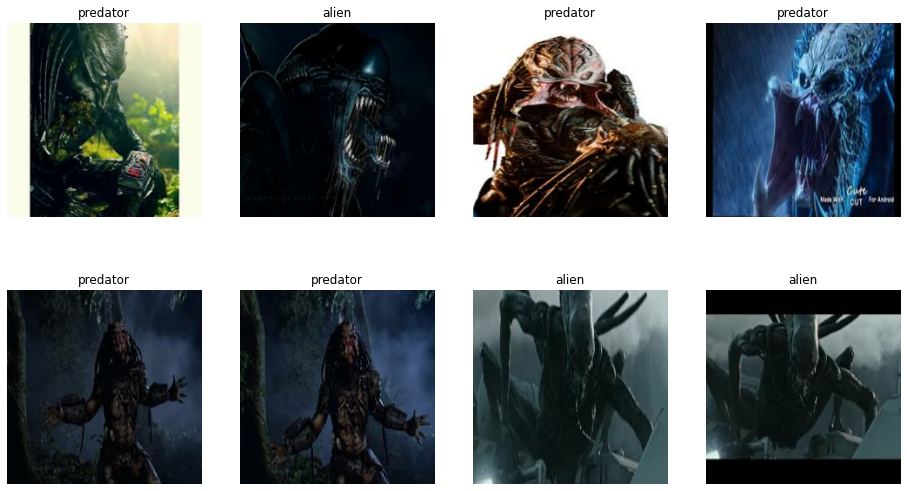

In [ ]:
plt.figure(figsize=(16, 9))
for images, labels in train_dataset.take(1):
    for i in range(BATCH_SIZE):
        plt.subplot(2, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[int(labels[i])])
        plt.axis("off")

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip, RandomRotation, RandomZoom

data_augmentation = Sequential(
  [
    RandomFlip(input_shape=(IMG_HEIGHT, IMG_WIDTH, 3), mode="horizontal"),  ## 
    RandomRotation(0.1),
    RandomZoom(0.1)
  ]
  , name="Argumentation"
)

In [ ]:
data_augmentation.summary()

Model: "Argumentation"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_flip (RandomFlip)    (None, 224, 224, 3)       0         
                                                                 
 random_rotation (RandomRota  (None, 224, 224, 3)      0         
 tion)                                                           
                                                                 
 random_zoom (RandomZoom)    (None, 224, 224, 3)       0         
                                                                 
Total params: 0
Trainable params: 0
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# test veriseti olusturduk
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)  # valid in %20 sini test e tasidik
validation_dataset = validation_dataset.skip(val_batches // 5)

In [ ]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 20
Number of test batches: 5


In [ ]:
# read-train zamanlarini senkronize ederek max verimi almamizi sagliyor
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_dataset = train_dataset.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)

# cache() # caches the dataset in memory (avoids having to reapply preprocessing transformations to the input)
# shuffle() # shuffle the samples to have always a random order of samples fed to the network

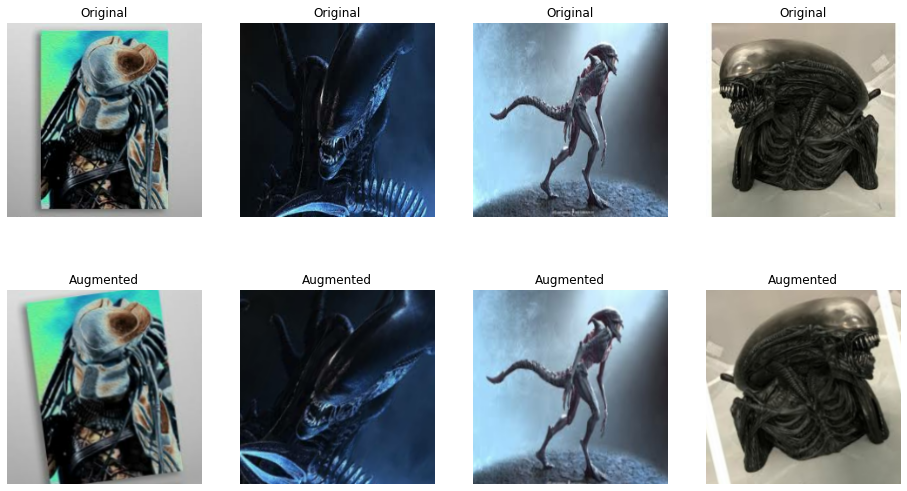

In [ ]:
plt.figure(figsize=(16, 9))
for images, labels in train_dataset.take(1):
    # Insert images into the data_augmentation
    argImg = data_augmentation(images)
    for i in range(int(BATCH_SIZE/2)):
       
        plt.subplot(2, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title("Original")
        plt.axis("off")
        
        plt.subplot(2, 4, i + 1 + int(BATCH_SIZE/2))
        plt.imshow(argImg[i].numpy().astype("uint8"))
        plt.title("Augmented")
        plt.axis("off")

In [ ]:
# bunu veya Rescaling metodunu kullan, calistirma
preprocess_input = tf.keras.applications.densenet.preprocess_input

In [ ]:
# rescale = tf.keras.layers.Rescaling(1./255, offset=-1)

# Model

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
from tensorflow.keras.losses import BinaryCrossentropy
# from tensorflow.keras import applications as pretrained
from tensorflow.keras.applications import DenseNet201

import math

In [ ]:
inputTensor = tf.keras.Input(shape=(IMG_HEIGHT,IMG_WIDTH,3))
print(inputTensor)

KerasTensor(type_spec=TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_2'), name='input_2', description="created by layer 'input_2'")


In [ ]:
# calistir

tf.random.set_seed(2000)

# Loading the base model
model_base = Sequential([
                          Rescaling(input_shape=(IMG_HEIGHT,IMG_WIDTH,3), scale=1.0/255, name="Rescailing"),
                          data_augmentation,
                          DenseNet201(input_shape=(IMG_HEIGHT,IMG_WIDTH,3), weights="imagenet", include_top=False)
], name="Base_DenseNet201")
model_base.trainable = False
model_base.summary()

featureTensor = model_base(inputTensor)  # burayi yorum satirina al

topLayers = Sequential([
                        GlobalAveragePooling2D(),
                        Dropout(0.2),
                        Dense(units=1, activation="sigmoid")
], name="Top_Layers")

# topLayers = CreatingTopLayers(featureTensor)

modified_model = Sequential([
  model_base,
  topLayers
], name="DenseNet201")
modified_model.summary()

74850304/74836368 [==============================] - 0s 0us/step
Model: "Base_DenseNet201"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Rescailing (Rescaling)      (None, 224, 224, 3)       0         
                                                                 
 Argumentation (Sequential)  (None, 224, 224, 3)       0         
                                                                 
 densenet201 (Functional)    (None, 7, 7, 1920)        18321984  
                                                                 
Total params: 18,321,984
Trainable params: 0
Non-trainable params: 18,321,984
_________________________________________________________________
Model: "DenseNet201"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Base_DenseNet201 (Sequentia  (None, 7, 7, 1920)       18321984  
 l)               

In [ ]:
modified_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001*3),
                         loss=losses.BinaryCrossentropy(from_logits=False),
                         metrics=['accuracy']
                         )

In [ ]:
early = EarlyStopping(monitor="val_loss", 
                      patience=math.floor(epochs*0.1))

learning_rate_reduction = ReduceLROnPlateau(monitor="val_loss", # val_loss iyilestirmeyi biraktiginda ogrenme oranini azaltir
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.3,
                                            min_lr=0.000001)

modelcheck = ModelCheckpoint('best_model.hdf5', monitor='val_accuracy',verbose=1,save_best_only=True,mode='max')

In [ ]:
history_DenseNet201 = modified_model.fit(
  train_dataset,
  validation_data=validation_dataset,
  epochs=epochs,
  callbacks=[modelcheck, learning_rate_reduction, early],
  verbose=1
)

Epoch 1/100
87/87 [==============================] - ETA: 0s - loss: 0.5048 - accuracy: 0.7651
Epoch 00001: val_accuracy improved from -inf to 0.86875, saving model to best_model.hdf5
87/87 [==============================] - 72s 604ms/step - loss: 0.5048 - accuracy: 0.7651 - val_loss: 0.2803 - val_accuracy: 0.8687 - lr: 0.0030
Epoch 2/100
87/87 [==============================] - ETA: 0s - loss: 0.2327 - accuracy: 0.9107
Epoch 00002: val_accuracy improved from 0.86875 to 0.90625, saving model to best_model.hdf5
87/87 [==============================] - 8s 87ms/step - loss: 0.2327 - accuracy: 0.9107 - val_loss: 0.2457 - val_accuracy: 0.9062 - lr: 0.0030
Epoch 3/100
87/87 [==============================] - ETA: 0s - loss: 0.2073 - accuracy: 0.9107
Epoch 00003: val_accuracy improved from 0.90625 to 0.91250, saving model to best_model.hdf5
87/87 [==============================] - 8s 96ms/step - loss: 0.2073 - accuracy: 0.9107 - val_loss: 0.2305 - val_accuracy: 0.9125 - lr: 0.0030
Epoch 4/100

In [ ]:
pd.DataFrame(modified_model.history_DenseNet201.history).plot()

NameError: ignored